# $\mathsf{CosmoFlow}$ Time Evolution

<div class="alert alert-block alert-info"> Please reach out to the developers if you have questions! Your questions and feedback are very valuable to us. </div>

In [1]:
# Import the standard Python packages
import numpy as np
import matplotlib.pyplot as plt
import time

# Import CosmoFlow modules (they must be located in the same parent folder as this notebook)
from Parameters import parameters
from Theory import theory
from Solver import solver

In [2]:
# Define the numerical i\epsilon prescription
def adiabatic(N_load, DeltaN):
    return (np.tanh((N_load + DeltaN - 1)/0.1) + 1)/2

## Different horizons

In [3]:
def horizons(cs, m, rho):
    n = 10000 # Number of points for the parameter evaluation
    N_load = np.linspace(-10, 20, n) # Time grid array in e-folds for the parameters
    DeltaN = 4.5 # Number of e-folds before horizon crossing
    
    # Theory 
    H_load = np.ones(n) # Hubble scale
    cs_load = cs * np.ones(n) # Speed of sound for phi
    m_load = m * np.ones(n) # Mass of Psi
    rho_load = rho * np.ones(n) * adiabatic(N_load, DeltaN) # Linear mixing strength
    lambda1_load = 1 * np.ones(n) * adiabatic(N_load, DeltaN) # Single-exchange coupling
    lambda2_load = 0 * np.ones(n) * adiabatic(N_load, DeltaN) # Double-exchange coupling
    lambda3_load = 0 * np.ones(n) * adiabatic(N_load, DeltaN) # Triple-exchange coupling
    
    # Load the parameters and define continuous functions
    param = parameters(N_load, H_load, cs_load, m_load, rho_load, lambda1_load, lambda2_load, lambda3_load) # Load the class parameters
    interpolated = param.output() # Define list with continuous parameters

    # Numerical parameters
    Nspan = np.linspace(-10, 20, 1000) # Time span in e-folds for the numerical integration
    Nfield = 2 # Number of fields
    Rtol, Atol = 1e-4, 1e-180 # Relative and absolute tolerance of the integrator
    N_exit = 0 # Horizon exit for a mode
    Ni, Nf = N_exit - DeltaN, 5 # Sets initial and final time for integration
    N = np.linspace(Ni, Nf, 1000) # Define the time array for output correlators

    # Initialise the integrator
    theo = theory(N = Nspan, Nfield = Nfield, interpolated = interpolated)
    
    k = theo.k_mode(N_exit) # Mode corresponding to N = 0 horizon exit
    k1, k2, k3 = k, k, k # Kinematic configuration for 3-pt function (here equilateral)
    
    s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
    f = s.f_solution(k1 = k1, k2 = k2, k3 = k3)
    return f, N

In [4]:
k, H = 1, 1
start_time = time.time() # Record running time

# Hubble horizon |k\tau| = 1
cs, m, rho = 1, 2, 0.1
N_HubbleCrossing = np.log(k/H)
f_HubbleCrossing, N = horizons(cs = cs, m = m, rho = rho)

# Sound horizon cs|k\tau| = 1
cs, m, rho = 0.1, 2, 0.1
N_SoundCrossing = np.log(cs * k/H)
f_SoundCrossing, N = horizons(cs = cs, m = m, rho = rho)

# Rho horizon |k\tau| = Sqrt[rho/H]
cs, m, rho = 1, 2, 10
N_RhoCrossing = np.log(k/H * (rho/H)**(-1/2))
f_RhoCrossing, N = horizons(cs = cs, m = m, rho = rho)

print("--- %s seconds ---" % (time.time() - start_time))

/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:112: RuntimeWarning: invalid value encountered in double_scalars
  d2 = norm((f1 - f0) / scale) / h0


--- 5.566046953201294 seconds ---


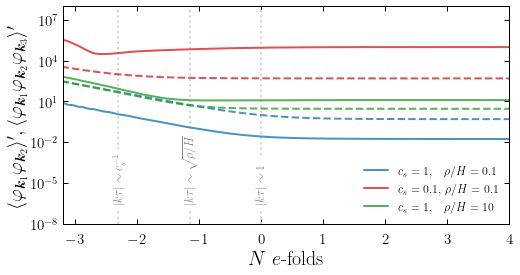

In [5]:
import matplotlib
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{bm}")

# Import figure style
plt.style.use('sty2.mplstyle')

# Define figure
fig = plt.figure()
ax = fig.add_subplot()

# Axis limits
ax.set_xlim([-3.2, 4])
ax.set_ylim([1e-8, 1e8])
ax.set_yticks([1e-8, 1e-4, 1, 1e4, 1e8])

# Plot horizons
ax.axvline(x = N_HubbleCrossing, ls = "dotted", color = "lightgray")
ax.text(N_HubbleCrossing, 1e-5, "$|k\\tau|\sim 1$", ha = 'center', va = 'center', rotation = 'vertical', backgroundcolor = 'white', color = "gray")
ax.axvline(x = N_SoundCrossing, ls = "dotted", color = "lightgray")
ax.text(N_SoundCrossing, 2e-5, "$|k\\tau|\sim c_s^{-1}$", ha = 'center', va = 'center', rotation = 'vertical', backgroundcolor = 'white', color = "gray")
ax.axvline(x = N_RhoCrossing, ls = "dotted", color = "lightgray")
ax.text(N_RhoCrossing, 1e-4, "$|k\\tau|\sim \sqrt{\\rho/H}$", ha = 'center', va = 'center', rotation = 'vertical', backgroundcolor = 'white', color = "gray")


# Plot field correlators
ax.semilogy(N, np.abs(f_HubbleCrossing[6][0, 0, 0]), color = "C0", alpha = 0.8, label = "$c_s = 1, \,\,\,\,\,\\rho/H = 0.1$")
ax.semilogy(N, np.abs(f_SoundCrossing[6][0, 0, 0]), color = "C1", alpha = 0.8, label = "$c_s = 0.1, \,\\rho/H = 0.1$")
ax.semilogy(N, np.abs(f_RhoCrossing[6][0, 0, 0]), color = "C2", alpha = 0.8, label = "$c_s = 1, \,\,\,\,\,\\rho/H = 10$")

ax.semilogy(N, np.abs(f_HubbleCrossing[0][0, 0]), color = "C0", ls = "--", alpha = 0.8)
ax.semilogy(N, np.abs(f_SoundCrossing[0][0, 0]), color = "C1", ls = "--", alpha = 0.8)
ax.semilogy(N, np.abs(f_RhoCrossing[0][0, 0]), color = "C2", ls = "--", alpha = 0.8)

# Labels
ax.set_xlabel(r"$N$ $e$-folds")
ax.set_ylabel(r"$\langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2}\rangle', \langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2} \varphi_{\bm{k}_3}\rangle'$")
ax.legend(ncol = 1, loc = 4)

# Save figure
plt.savefig('PhiPsi_DifferentHorizons.pdf', bbox_inches = "tight")

## Various cubic interactions

In [6]:
def cubic(lambda1, lambda2, lambda3, kinematic):
    n = 10000 # Number of points for the parameter evaluation
    N_load = np.linspace(-10, 20, n) # Time grid array in e-folds for the parameters
    DeltaN = 5 # Number of e-folds before horizon crossing
    
    # Theory 
    H_load = np.ones(n) # Hubble scale
    cs_load = 1 * np.ones(n) # Speed of sound for phi
    m_load = 2 * np.ones(n) # Mass of Psi
    rho_load = 0.1 * np.ones(n) * adiabatic(N_load, DeltaN) # Linear mixing strength
    lambda1_load = lambda1 * np.ones(n) * adiabatic(N_load, DeltaN) # Single-exchange coupling
    lambda2_load = lambda2 * np.ones(n) * adiabatic(N_load, DeltaN) # Double-exchange coupling
    lambda3_load = lambda3 * np.ones(n) * adiabatic(N_load, DeltaN) # Triple-exchange coupling
    
    # Load the parameters and define continuous functions
    param = parameters(N_load, H_load, cs_load, m_load, rho_load, lambda1_load, lambda2_load, lambda3_load) # Load the class parameters
    interpolated = param.output() # Define list with continuous parameters

    # Numerical parameters
    Nspan = np.linspace(-10, 20, 1000) # Time span in e-folds for the numerical integration
    Nfield = 2 # Number of fields
    Rtol, Atol = 1e-5, 1e-180 # Relative and absolute tolerance of the integrator
    N_exit = 0 # Horizon exit for a mode
    Ni, Nf = N_exit - DeltaN, 5 # Sets initial and final time for integration
    N = np.linspace(Ni, Nf, 1000) # Define the time array for output correlators

    # Initialise the integrator
    theo = theory(N = Nspan, Nfield = Nfield, interpolated = interpolated)
    
    k = theo.k_mode(N_exit) # Mode corresponding to N = 0 horizon exit
    if kinematic == "equilateral":
        k1, k2, k3 = k, k, k # Kinematic configuration for 3-pt function (here equilateral)
    elif kinematic == "squeezed":
        k1, k2, k3 = 5*k, 5*k, k # Kinematic configuration for 3-pt function (here mildly squeezed)
    
    s = solver(Nspan = N, Nfield = Nfield, interpolated = interpolated, Rtol = Rtol, Atol = Atol)
    f = s.f_solution(k1 = k1, k2 = k2, k3 = k3)
    return f, N

In [7]:
start_time = time.time() # Record running time

f1_eq, N = cubic(lambda1 = 1, lambda2 = 0, lambda3 = 0, kinematic = "equilateral")
f2_eq, N = cubic(lambda1 = 0, lambda2 = 1, lambda3 = 0, kinematic = "equilateral")
f3_eq, N = cubic(lambda1 = 1e-50, lambda2 = 0, lambda3 = 1, kinematic = "equilateral")

f1_sq, N = cubic(lambda1 = 1, lambda2 = 0, lambda3 = 0, kinematic = "squeezed")
f2_sq, N = cubic(lambda1 = 0, lambda2 = 1, lambda3 = 0, kinematic = "squeezed")
f3_sq, N = cubic(lambda1 = 1e-50, lambda2 = 0, lambda3 = 1, kinematic = "squeezed")

print("--- %s seconds ---" % (time.time() - start_time))

/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:112: RuntimeWarning: invalid value encountered in double_scalars
  d2 = norm((f1 - f0) / scale) / h0


--- 51.14741611480713 seconds ---


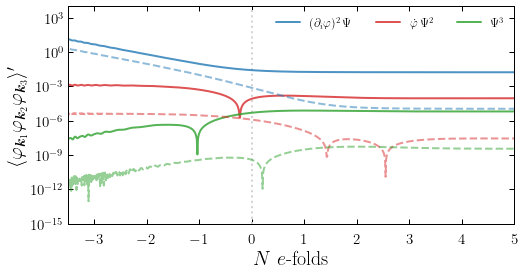

In [8]:
import matplotlib
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r"\usepackage{bm}")

# Import figure style
plt.style.use('sty2.mplstyle')

# Define figure
fig = plt.figure()
ax = fig.add_subplot()

# Axis limits
ax.set_xlim([-3.5, 5])
ax.set_ylim([1e-15, 1e4])

# Horizon crossing
ax.axvline(x = 0, ls = "dotted", color = "lightgray")

# Plot field correlators
ax.semilogy(N, np.abs(f1_eq[6][0, 0, 0]), color = "C0", alpha = 0.8, label = "$(\partial_i \\varphi)^2\,\Psi$")
ax.semilogy(N, np.abs(f2_eq[6][0, 0, 0]), color = "C1", alpha = 0.8, label = "$\dot{\\varphi}\,\Psi^2$")
ax.semilogy(N, np.abs(f3_eq[6][0, 0, 0]), color = "C2", alpha = 0.8, label = "$\Psi^3$")

ax.semilogy(N, np.abs(f1_sq[6][0, 0, 0]), color = "C0", alpha = 0.5, ls = "--")
ax.semilogy(N, np.abs(f2_sq[6][0, 0, 0]), color = "C1", alpha = 0.5, ls = "--")
ax.semilogy(N, np.abs(f3_sq[6][0, 0, 0]), color = "C2", alpha = 0.5, ls = "--")



# Labels
ax.set_xlabel(r"$N$ $e$-folds")
ax.set_ylabel(r"$\langle\varphi_{\bm{k}_1} \varphi_{\bm{k}_2} \varphi_{\bm{k}_3}\rangle'$")
ax.legend(ncol = 3, loc = 1)

# Save figure
plt.savefig('PhiPsi_CubicInteractions.pdf', bbox_inches = "tight")